Image dataset containing samples of meningioma(1), glioma(2), pituitary tumor(3) brain tumor types.

Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5

# Zaimportowanie potrzebnych bibliotek

In [1]:
from PIL import Image
from numpy import asarray
import os
import sklearn.model_selection as ms
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import random
from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import KMeans

# Podanie ścieżek do poszczególnych folderów z klasami

In [2]:
classes_paths = ["data_UL/Glioma", "data_UL/Meningioma", "data_UL/Pituitary"]

classes = []

# Przekonwertowanie zdjęć do ramek numpy w formacie RGB

In [3]:
for name in os.listdir("data_UL"):
    classes.append(name)

x, y = [], []

for idx, dire in enumerate(classes_paths):
    for filename in os.listdir(dire):
        if os.path.isfile(os.path.join(dire, filename)):
            img = Image.open(os.path.join(dire, filename)).convert('RGB')
            img = img.resize((224, 224))
            data = asarray(img)
            x.append(data)
            y.append([idx, os.path.join(dire, filename)]) # y to jest prawdziwa labelka plus nazwa zdjęcia, będzie to potrzebne to odczytywania odpowiednich zdjęć po ekstrakcji cech

data_array = [x, y]

# Rozdzielenie danych na zbiory treningowe i testowe

In [4]:
x_train, x_test, y_train, y_test = ms.train_test_split(data_array[0], data_array[1], test_size=0.2, shuffle=True)
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

print(len(x_train))

Total training examples: 2451
Total test examples: 613
2451


# Ekstrakcja cech ze zdjęć, za pomocą pretrenowanej sieci VGG16

In [5]:
vgg_model = VGG16(weights='imagenet', include_top=False)
batch_size = 32

all_features = []

for i in range(0, len(x_train), batch_size):
    batch_images = x_train[i:i + batch_size]
    batch_preprocessed = np.array([preprocess_input(img) for img in batch_images])

    batch_features = vgg_model.predict(batch_preprocessed)
    all_features.append(batch_features)

all_features = np.concatenate(all_features, axis=0)

print('Shape of extracted features:', all_features.shape)

1/1 [==============================] - 3s 3s/step
Shape of extracted features: (2451, 7, 7, 512)


# Zwizualizowanie na wykresie cech wyekstrahowanych z przykładowego zdjęcia

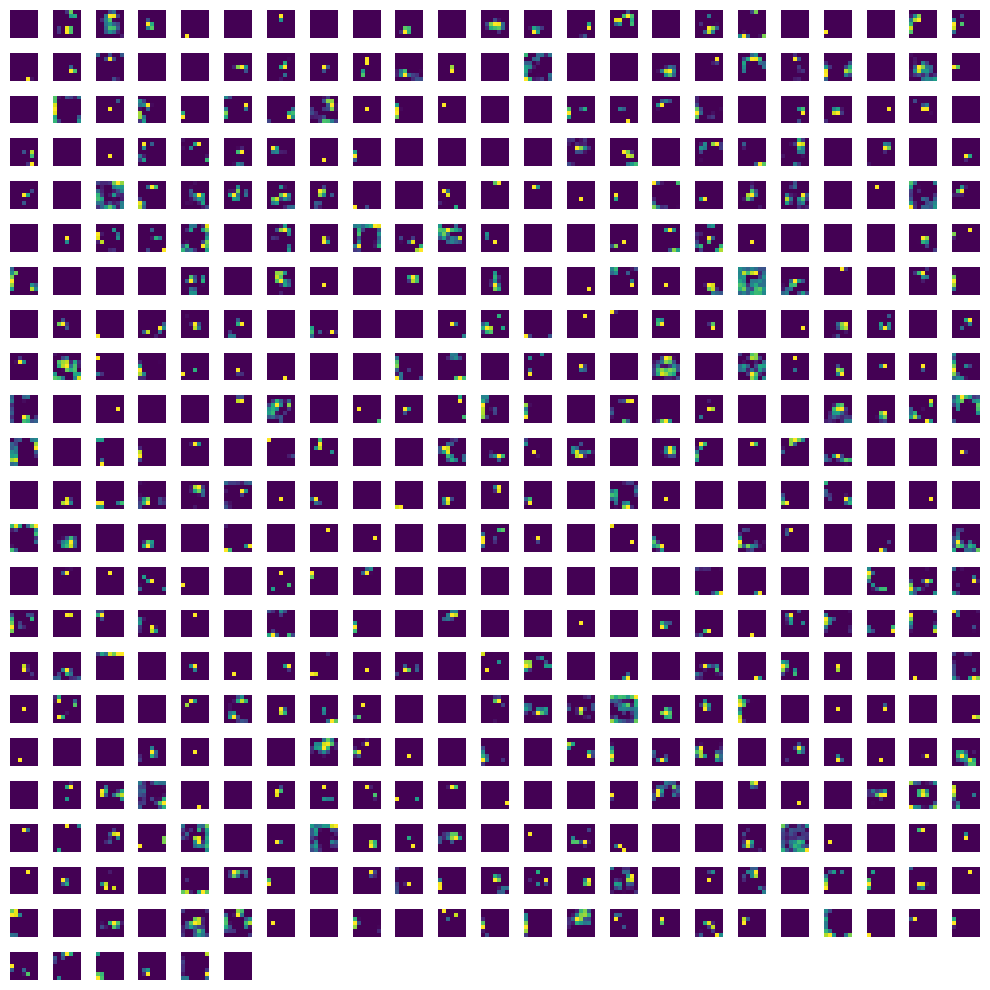

In [6]:
features = all_features[1]

num_feature_maps = features.shape[-1]
grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    if i < num_feature_maps:
        feature_map = features[:, :, i]
        ax.imshow(feature_map)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


Złączenie cech w jedną ramkę numpy

In [7]:
print(len(all_features))
print(len(x_train))

# Rozmiar ramki z cechami powinien równać się rozmiarowi ramki danych treningowych

2451
2451


# Zmieniamy wymiar cech z 4D na 2D aby można było je podać do modelu grupowania

In [8]:
num_samples, height, width, num_features = all_features.shape
d2_features = all_features.reshape(num_samples, height * width * num_features)

# Klasteryzacja zdjęć wykonana za pomocą Agglomerative Clustering

In [9]:
num_clusters = 3

agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglomerative.fit_predict(d2_features)

# Zwizualizowanie wyniku klasteryzacji

Real labels[0, 0, 0, 2, 0]
Real labels[0, 2, 1, 2, 1]
Real labels[1, 1, 1, 1, 2]


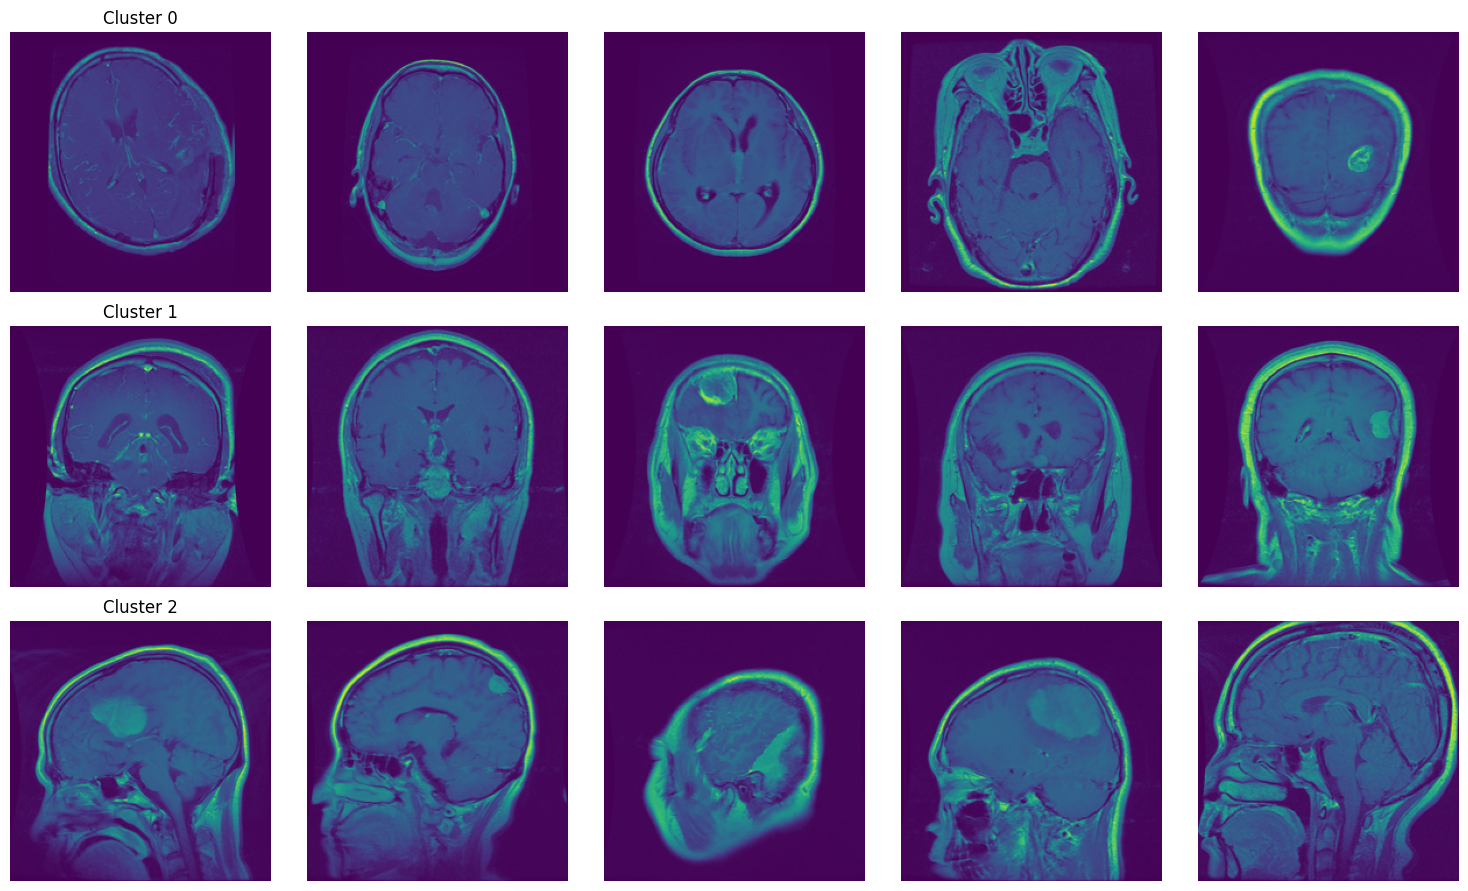

In [10]:
number_of_images = 5

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

for cluster_id in range(num_clusters):

    cluster_indices = np.where(clusters == cluster_id)[0]
    random_indices = random.sample(list(cluster_indices), number_of_images)

    real_labels = []
    image_indexes = []

    for i, image_index in enumerate(random_indices):

        image_array = x_train[image_index]
        real_labels.append(y_train[image_index][0])
        image_indexes.append(y_train[image_index][1])

        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Real labels{real_labels}")


plt.tight_layout()
plt.show()

# Dwie funkcje aby sprawdzić jakość grupowania posiadając informację o prawdziwych etykietach

In [11]:
clusters_reallabels = []

for _ in range(num_clusters):
    clusters_reallabels.append([])

for cluster_id in range(num_clusters):
    real_labels = []
    cluster_indices = np.where(clusters == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x][0])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1


print(counts)

[{'0': 401, '1': 167, '2': 232}, {'0': 411, '1': 185, '2': 251}, {'0': 340, '1': 214, '2': 250}]


In [12]:
def custom_cluster_accuracy(counts, n_classes):

    percentages = []
    for x in range(n_classes):
        percentages.append([])

    for idx, x in enumerate(percentages):
        suma = 0
        for s in range(n_classes):
            suma += counts[idx][str(s)]
        for i in range(n_classes):
             percentages[idx].append(counts[idx][str(i)] / suma)

    fi = n_classes*(1-1/n_classes+(n_classes-1)*1/n_classes)
    loss = fi

    for x in percentages:
        for i in x:
            loss -= abs(1/n_classes - i)

    print(f"Custom cluster accuracy 0-1: {round(1-loss/fi, 5)}")

In [13]:
custom_cluster_accuracy(counts, len(classes))

Custom cluster accuracy 0-1: 0.20469


# Grupowanie rozdzieliło zdjęcia na typ osi przekroju, przeprowadzona zostaje zatem próba grupowowania na rozdzielonych już klastrach

In [14]:
x_clustered = []

for cluster_id in range(num_clusters):
    x_clustered.append(list(np.where(clusters == cluster_id)[0]))

x_clustered_dict = {"Upper": x_clustered[0], "Front": x_clustered[1], "Side": x_clustered[2]}

### Klasteryzacja widoku z góry

In [15]:
num_clusters = 3
x_upper = [[i, idx] for idx, i in enumerate(d2_features) if idx in x_clustered_dict["Upper"]]
x_upper_indexes = [x[1] for x in x_upper]
x_upper_features = [x[0] for x in x_upper]
agglomerative_upper = AgglomerativeClustering(n_clusters=num_clusters)
clusters_upper = agglomerative.fit_predict(x_upper_features)

Real labels[0, 1, 0, 0, 0]
Real labels[0, 2, 0, 0, 0]
Real labels[2, 2, 2, 2, 2]


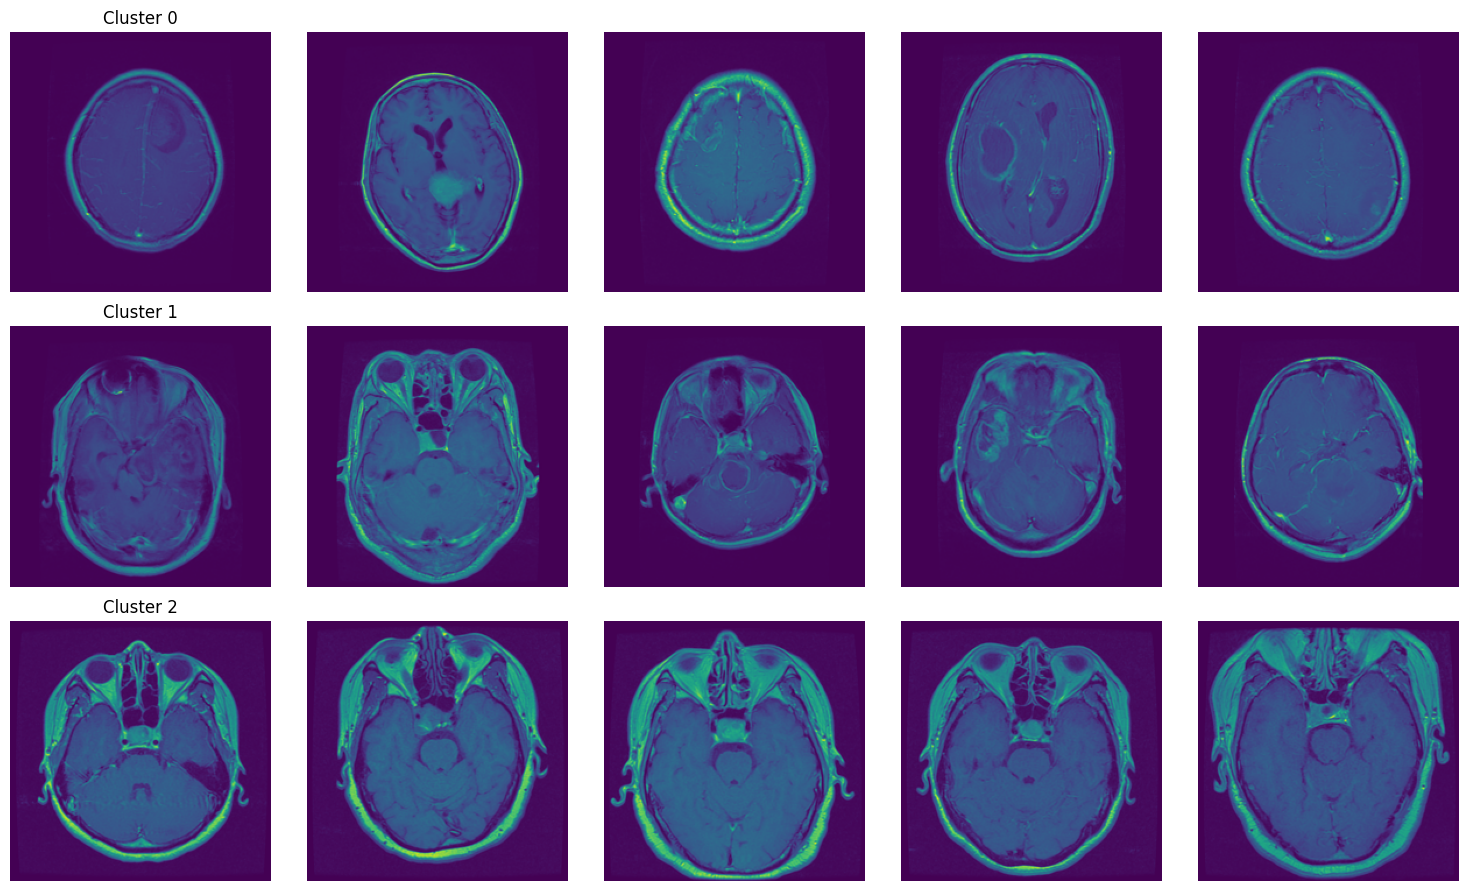

In [16]:
number_of_images = 5

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

for cluster_id in range(num_clusters):

    cluster_indices = np.where(clusters_upper == cluster_id)[0]
    random_indices = random.sample(list(cluster_indices), number_of_images)

    real_labels = []
    image_indexes = []

    for i, image_index in enumerate(random_indices):

        image_array = x_train[x_upper_indexes[image_index]]
        real_labels.append(y_train[x_upper_indexes[image_index]][0])
        image_indexes.append(y_train[x_upper_indexes[image_index]][1])

        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Real labels{real_labels}")


plt.tight_layout()
plt.show()

In [17]:
clusters_reallabels = []

for _ in range(num_clusters):
    clusters_reallabels.append([])

for cluster_id in range(num_clusters):
    real_labels = []
    cluster_indices = np.where(clusters_upper == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x_upper_indexes[x]][0])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1


print(counts)
custom_cluster_accuracy(counts, 3)

[{'0': 318, '1': 104, '2': 0}, {'0': 83, '1': 59, '2': 120}, {'0': 0, '1': 4, '2': 112}]
Custom cluster accuracy 0-1: 0.58854


### Klasteryzacja widoku od przodu

In [18]:
num_clusters = 3
x_front = [[i, idx] for idx, i in enumerate(d2_features) if idx in x_clustered_dict["Front"]]
x_front_indexes = [x[1] for x in x_front]
x_front_features = [x[0] for x in x_front]
agglomerative_front = AgglomerativeClustering(n_clusters=num_clusters)
clusters_front = agglomerative.fit_predict(x_front_features)

Real labels[2, 2, 2, 2, 1]
Real labels[0, 0, 0, 0, 1]
Real labels[0, 0, 0, 0, 0]


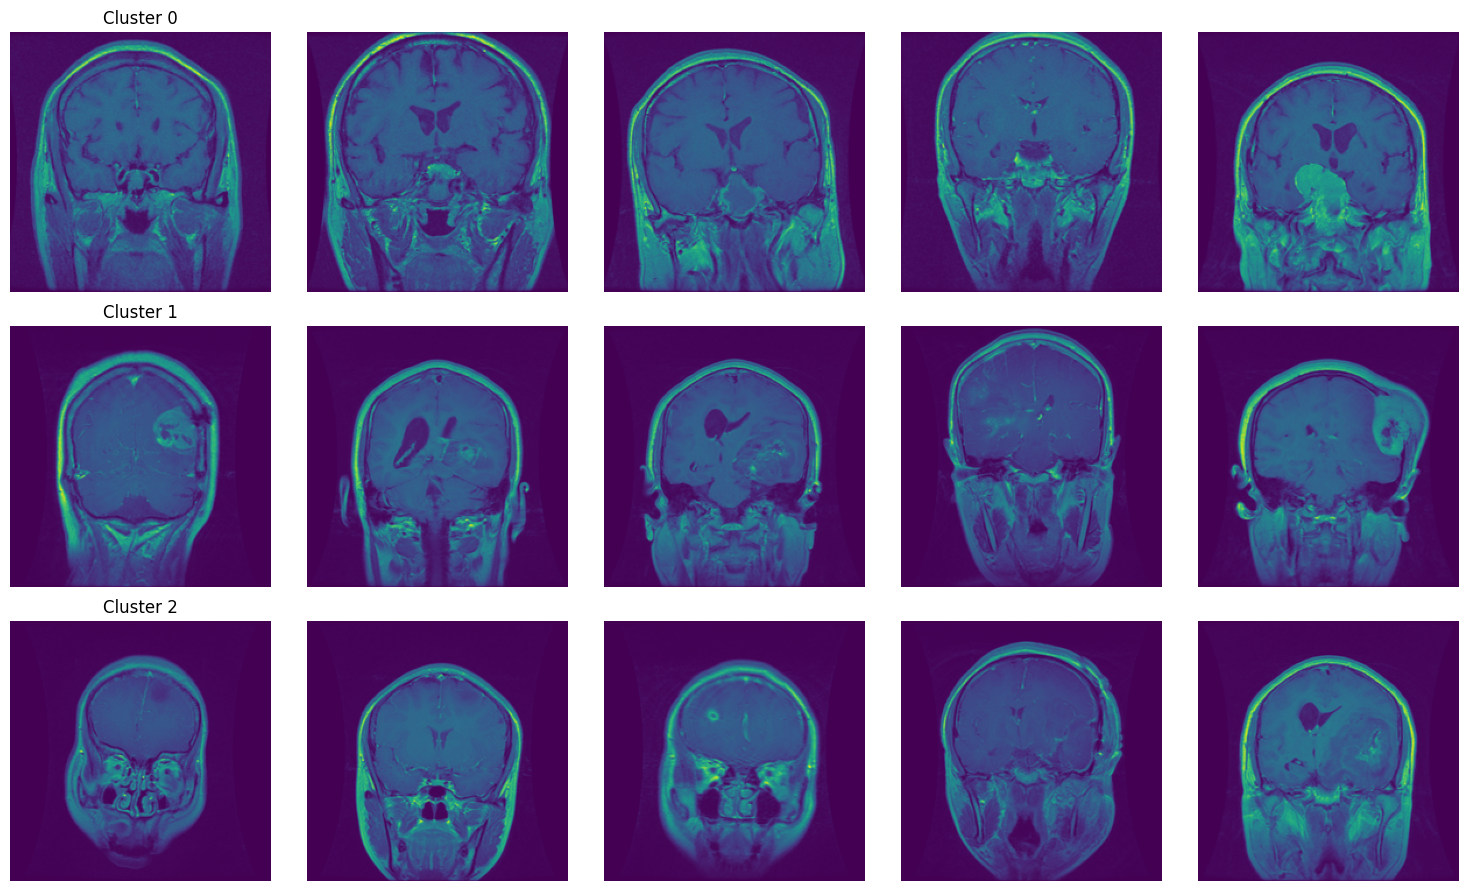

In [19]:
number_of_images = 5

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

for cluster_id in range(num_clusters):

    cluster_indices = np.where(clusters_front == cluster_id)[0]
    random_indices = random.sample(list(cluster_indices), number_of_images)

    real_labels = []
    image_indexes = []

    for i, image_index in enumerate(random_indices):

        image_array = x_train[x_front_indexes[image_index]]
        real_labels.append(y_train[x_front_indexes[image_index]][0])
        image_indexes.append(y_train[x_front_indexes[image_index]][1])

        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Real labels{real_labels}")


plt.tight_layout()
plt.show()

In [20]:
clusters_reallabels = []

for _ in range(num_clusters):
    clusters_reallabels.append([])

for cluster_id in range(num_clusters):
    real_labels = []
    cluster_indices = np.where(clusters_front == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x_front_indexes[x]][0])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1


print(counts)
custom_cluster_accuracy(counts, 3)

[{'0': 0, '1': 17, '2': 245}, {'0': 207, '1': 115, '2': 1}, {'0': 204, '1': 53, '2': 5}]
Custom cluster accuracy 0-1: 0.68866


### Klasteryzacja widoku od boku

In [21]:
num_clusters = 3
x_side = [[i, idx] for idx, i in enumerate(d2_features) if idx in x_clustered_dict["Side"]]
x_side_indexes = [x[1] for x in x_side]
x_side_features = [x[0] for x in x_side]
agglomerative_side = AgglomerativeClustering(n_clusters=num_clusters)
clusters_side = agglomerative.fit_predict(x_side_features)

Image indexes['data_UL/Glioma\\376.png', 'data_UL/Meningioma\\2457.png', 'data_UL/Glioma\\1990.png', 'data_UL/Glioma\\279.png', 'data_UL/Glioma\\394.png']
Real labels[0, 1, 0, 0, 0]
Image indexes['data_UL/Glioma\\1911.png', 'data_UL/Meningioma\\2478.png', 'data_UL/Glioma\\1940.png', 'data_UL/Glioma\\1932.png', 'data_UL/Pituitary\\979.png']
Real labels[0, 1, 0, 0, 2]
Image indexes['data_UL/Pituitary\\2279.png', 'data_UL/Pituitary\\965.png', 'data_UL/Meningioma\\2482.png', 'data_UL/Pituitary\\925.png', 'data_UL/Pituitary\\2250.png']
Real labels[2, 2, 1, 2, 2]


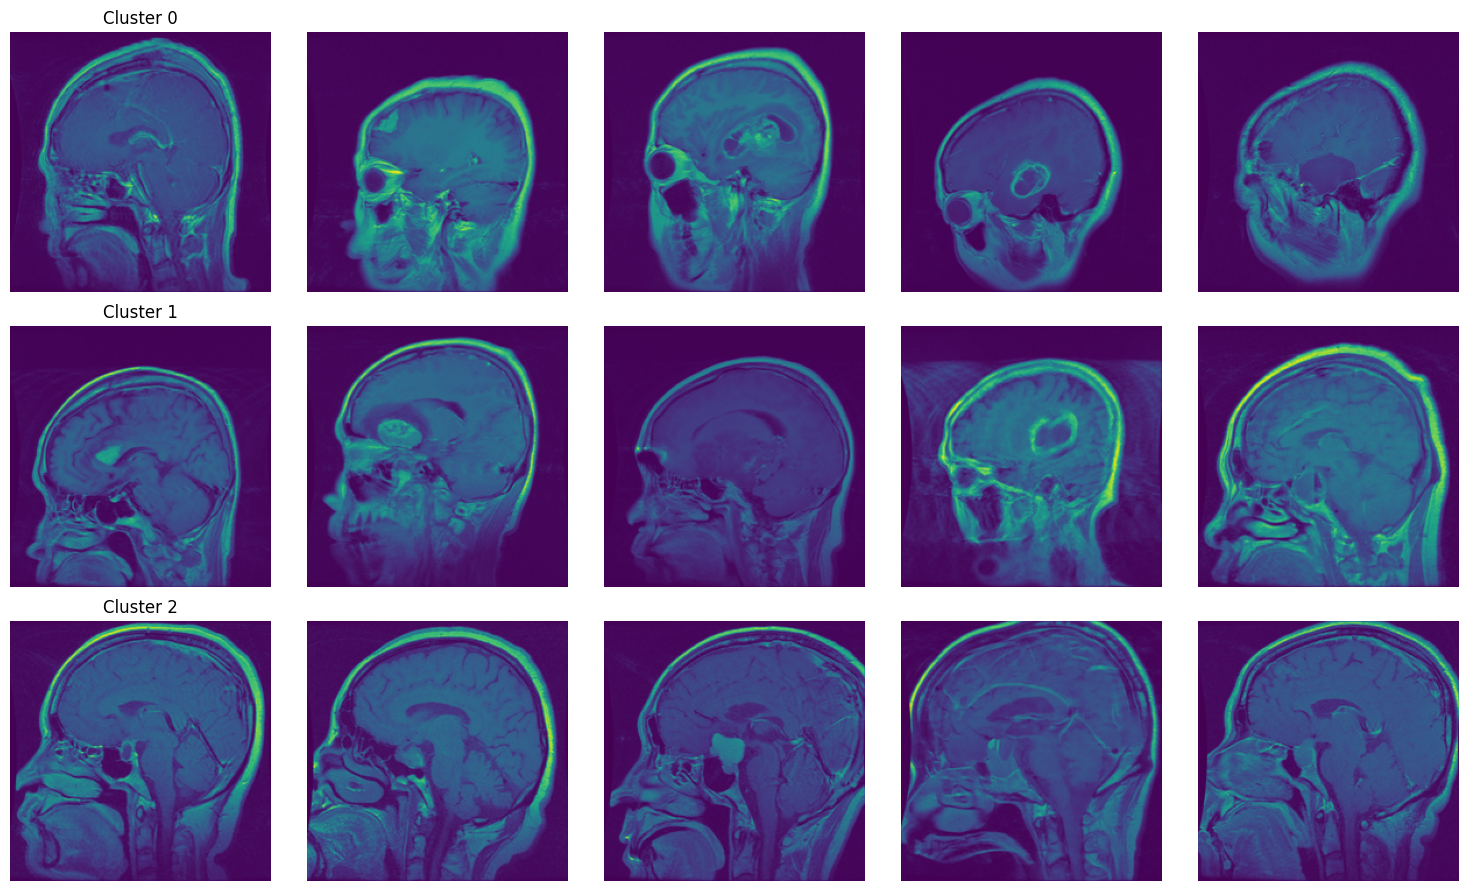

In [22]:
number_of_images = 5

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

for cluster_id in range(num_clusters):

    cluster_indices = np.where(clusters_side == cluster_id)[0]
    random_indices = random.sample(list(cluster_indices), number_of_images)

    real_labels = []
    image_indexes = []

    for i, image_index in enumerate(random_indices):

        image_array = x_train[x_side_indexes[image_index]]
        real_labels.append(y_train[x_side_indexes[image_index]][0])
        image_indexes.append(y_train[x_side_indexes[image_index]][1])

        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Image indexes{image_indexes}")
    print(f"Real labels{real_labels}")


plt.tight_layout()
plt.show()

In [23]:
clusters_reallabels = []

for _ in range(num_clusters):
    clusters_reallabels.append([])

for cluster_id in range(num_clusters):
    real_labels = []
    cluster_indices = np.where(clusters_side == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x_side_indexes[x]][0])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1


print(counts)
custom_cluster_accuracy(counts, 3)

[{'0': 218, '1': 73, '2': 0}, {'0': 120, '1': 133, '2': 97}, {'0': 2, '1': 8, '2': 153}]
Custom cluster accuracy 0-1: 0.53866
